## **Is it a bird?**

In [9]:
!pip install -Uqq fastai duckduckgo_search

#Import necessary Libraries
from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.all import *
import time, json
import os

In [40]:
#Define a function to search for images
def search_images(keywords, max_images = 100):
  return L(DDGS().images(keywords, max_results = max_images)).itemgot('image')

In [41]:
# Search for bird photos
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/97533/pexels-photo-97533.jpeg?cs=srgb&dl=animal-avian-bird-97533.jpg&fm=jpg'

In [42]:
# Download the bird photos
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

Path('bird.jpg')

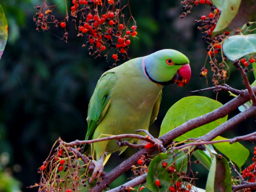

In [43]:
# Display the downloaded image
im = Image.open(dest)
im.to_thumb(256,256)


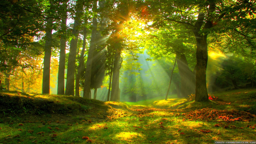

In [44]:
# Download forest photo
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [51]:
# Define search terms and path
searches = 'forest','bird'
path = Path('bird_or_not')

# Clean existing directories to avoid conflicts
if path.exists():
    shutil.rmtree(path)
path.mkdir(exist_ok=True)

# Download images with sanitized filenames
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    print(f"Downloading {o} images...")
    urls = search_images(f'{o} photo', max_images=30)  # Download extras
    for idx, url in enumerate(urls):
        try:
            # Clean filename: Remove query params and invalid characters
            filename = url.split("/")[-1].split("?")[0]
            filename = os.path.basename(filename)
            # Ensure filename has an image extension
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                filename += '.jpg'
            !wget -q -O {dest}/{filename} {url}
        except Exception as e:
            print(f'Error downloading {url}: {e}')
    time.sleep(5)  # Avoid server blocks
    resize_images(path/o, max_size=400, dest=path/o)

# Remove corrupted files
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f"Removed {len(failed)} bad images.")

# Check remaining files
print("Bird images:", len(os.listdir(path/'bird')))
print("Forest images:", len(os.listdir(path/'forest')))



bird_or_not/forest/sunlight-trees-forest-nature-road-morning-mist-wilderness-jungle-rainforest-wetland-tree-autumn-woodland-3840x2400-px-habitat-natural-environment-atmospheric-phenomenon-woody-plant-geographical-feature-ecosystem-temperate-coniferous-forest-biome-old-growth-forest-temperate-broadleaf-and-mixed-forest-deciduous-730487.jpg: File name too long
bird_or_not/forest/landscape-tree-nature-forest-wilderness-branch-light-plant-wood-mist-meadow-sunlight-morning-leaf-spring-green-jungle-natural-autumn-season-rainforest-bright-deciduous-rays-woodland-habitat-ecosystem-forest-landscape-biome-old-growth-forest-natural-environment-geographical-feature-atmospheric-phenomenon-woody-plant-temperate-broadleaf-and-mixed-forest-temperate-coniferous-forest-632910.jpg: File name too long
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `wget -q -O bird_or_not/forest/GettyImages-168346757-8c08397c6e314a12b29e87d16f337996.jpg https://www.treehugger.com/thmb/

In [52]:
# Rebuild DataLoaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

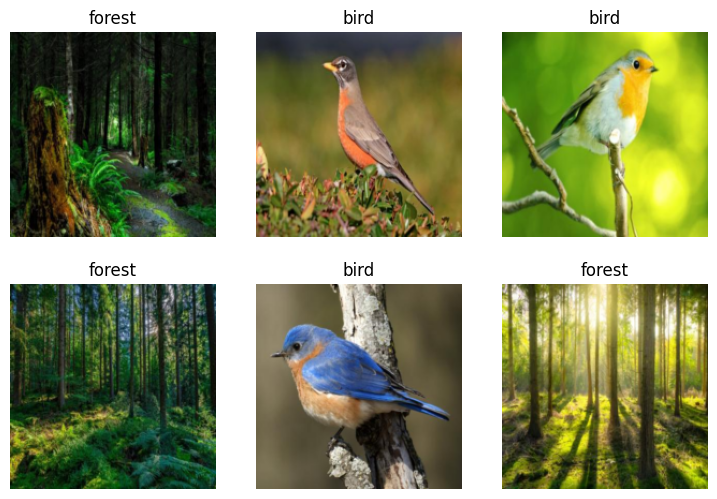

In [53]:
# Display a batch of images
dls.show_batch(max_n=6)

In [54]:
# Train the model

learn = vision_learner(dls, resnet18, metrics= error_rate)
learn.fine_tune(3)

#Make a prediction
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.618263,1.910076,0.444444,00:07


epoch,train_loss,valid_loss,error_rate,time
0,2.167115,1.368930,0.444444,00:08
1,1.422815,0.667370,0.333333,00:09
2,0.989081,0.239563,0.111111,00:09


This is a: bird.
Probability it's a bird: 1.0000
